# Regional effects of sediment lubrication on plate velocities 

Thomas Schouten, Whitney Behr, Edward Clennett and Thorsten Becker


In [1]:
# Import packages
import numpy as np
import pandas as pd
import xarray as xr
import gplately
from gplately import pygplates
import matplotlib.pyplot as plt
import cmcrameri as cmc

# Import preprocessing functions
from preprocessing import get_plates
from preprocessing import get_points_with_plate_ids
from preprocessing import get_subduction_zones
from preprocessing import get_options

# Import torque calculation functions
from plate_force_calculation import compute_torques

# Import postprocessing functions
from postprocessing import optimise_coefficients

# Import plotting functions
from plotting import plot_torques

In [2]:
# Set reconstruction_times
reconstruction_times = [0, 100, 180]

### Load Files

First, we load the files from the data folder. These consist of:

- GPlates files containing the rotations, plate boundaries and coastlines of the Müller et al., 2016 model.
- A raster containing the age of the seafloor and the thickness of the overlying sediments
- Three .csv files containing data on the plates, 

In [3]:
# Load gplates reconstruction files
rotation_file = pygplates.RotationModel("data/Global_EarthByte_230-0Ma_GK07_AREPS.rot")
topology_features = pygplates.FeatureCollection("data/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml")
coastlines = pygplates.FeatureCollection("data/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpml")
reconstruction_files = (rotation_file, topology_features, coastlines)

# Load rasters
seafloor = {}
plates = {}
grid = {}
subduction_zones = {}
for reconstruction_time in reconstruction_times:
    seafloor[reconstruction_time] = xr.open_dataset("data/Seafloor_Muller2016_" + str(reconstruction_time) + "Ma.nc")
    plates[reconstruction_time] = pd.read_csv("data/Plates_Muller2016_" + str(reconstruction_time) + "Ma.csv")
    grid[reconstruction_time] = pd.read_csv("data/Points_Muller2016_" + str(reconstruction_time) + "Ma.csv")
    subduction_zones[reconstruction_time] = pd.read_csv("data/Subduction_zones_Muller2016_" + str(reconstruction_time) + "Ma.csv")

### Preprocessing steps

If you want to run PLATEFO for different reconstruction times or with a different reconstruction, you will need to generate new rasters, which we can be done by executing the following cells.

These preprocessing steps can be time-consuming, so we execute them before running the main code to accelerate the plate forces calculation.

In [4]:
# Comment any of these to keep loaded files
resolved_topologies = {}

# Set grid and tesselation spacing
grid_spacing = 1            # [deg]
tesselation_spacing = 250   # [km]

# Set output directory and reconstruction name
output_directory = "data"
reconstruction_name = "Muller2016"

# Generate preprocessing files for each reconstruction
# for reconstruction_time in reconstruction_times:
#     plates[reconstruction_time], resolved_topologies[reconstruction_time] = get_plates(topology_features, rotation_file, reconstruction_time, output_directory, reconstruction_name)
#     grid[reconstruction_time] = get_points_with_plate_ids(resolved_topologies[reconstruction_time], rotation_file, reconstruction_time, grid_spacing, output_directory, reconstruction_name)
#     subduction_zones[reconstruction_time] = get_subduction_zones(rotation_file, topology_features, reconstruction_time, tesselation_spacing, output_directory, reconstruction_name)

### Setting the options for each "ref" study

Now we set the options for the case study. These can be set in an excel file. You need to provide a name for each case in the column "Name" and can set each option in the column with the respective name. If the value in the column in empty or if the column does not exist, the default value will apply.

The options are (default value in **bold**):
- Slab pull torque: **True**/False
- GPE torque: **True**/False
- Mantle drag torque: **True**/False
- Bending torque: True/**False**
- Bending mechanism: **viscous**/plastic
- Reconstructed motions: **True**/False
- Continental crust: True/**False**
- Seafloor age profile: **half space cooling**/plate model
- Shear zone width: **1 km**
- Sediment subduction: True/**False**
- Interface mixing: **linear**/threshold
- Passive margin sediments: True/**False**
- Active margin sediments: True/**False**
- Equatorial bulge sediments: True/**False**
- Generalised sediments: True/**False**

In [5]:
# Open cases file
cases_file = "Cases.xlsx"

cases, options = get_options(cases_file)

### Plate force calculation

Now we can perform the plate force calculation

In [6]:
# Initialise dictionaries to store data
plate_torques = {}
slabs = {}
points = {}

# Loop through reconstruction times
for reconstruction_time in reconstruction_times:
    plate_torques[reconstruction_time], slabs[reconstruction_time], points[reconstruction_time] = compute_torques(
        plates[reconstruction_time], 
        subduction_zones[reconstruction_time], 
        grid[reconstruction_time], 
        seafloor[reconstruction_time], 
        cases, 
        options)

In [7]:
slabs[100]["test"]

,Unnamed: 0,lon,lat,v_convergence,obliquity_convergence,v_absolute,obliquity_absolute,trench_segment_length,trench_normal_azimuth,lower_plateID,...,upper_plate_thickness,lower_plate_age,sediment_thickness,lower_plate_thickness,effective_slab_pull_force,v_theoretical,v_theoretical_lat,v_theoretical_lon,effective_slab_pull_force_lat,effective_slab_pull_force_lon
0,0,-96.105516,-72.965789,21.245993,335.571146,4.074718,204.754049,42378.313803,167.118417,919.0,...,100000.0,28.360544,0.0,69406.036906,5.662142e+13,1.690909e-10,-1.648353e-10,3.769657e-11,-3.114125e+13,7.121763e+12
1,1,-93.379302,-72.666253,21.180734,343.486377,4.002699,213.348021,149240.554833,156.540510,919.0,...,100000.0,28.788722,0.0,69928.009073,5.704724e+13,1.703557e-10,-1.562744e-10,6.781871e-11,-2.952507e+13,1.281305e+13
2,2,-90.067672,-72.148029,21.086651,349.157437,3.912548,220.037250,101962.220587,147.647969,919.0,...,100000.0,29.309044,0.0,70557.111560,5.756046e+13,1.718799e-10,-1.452001e-10,9.197634e-11,-2.743412e+13,1.737802e+13
3,3,-87.656242,-71.598546,21.001426,354.472974,3.844779,226.326864,105281.201168,140.007423,919.0,...,100000.0,27.705121,0.0,68599.349574,5.596332e+13,1.671357e-10,-1.280473e-10,1.074161e-10,-2.418966e+13,2.029219e+13
4,4,-85.548709,-71.132031,20.922773,339.715433,3.781953,212.419062,78577.260108,152.722843,919.0,...,100000.0,28.021569,0.0,68990.007530,5.628202e+13,1.680826e-10,-1.493918e-10,7.703144e-11,-2.822272e+13,1.455258e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,486,-120.903382,-72.258068,21.606307,333.949806,4.732009,199.943127,171797.332259,193.006254,919.0,...,100000.0,3.646566,0.0,24887.542643,2.030325e+13,6.073400e-11,-5.917590e-11,-1.366864e-11,-1.116101e+13,-2.578006e+12
487,487,-115.397704,-72.625048,21.545353,330.078059,4.587775,196.739929,206971.403190,191.541785,919.0,...,100000.0,6.509238,0.0,33251.026756,2.712617e+13,8.113462e-11,-7.949400e-11,-1.623362e-11,-1.499484e+13,-3.062124e+12
488,488,-109.816187,-72.891823,21.472530,329.342479,4.440960,196.678064,165976.911845,186.833122,919.0,...,100000.0,9.265451,0.0,39671.008541,3.236359e+13,9.678673e-11,-9.609925e-11,-1.151549e-11,-1.812950e+13,-2.172443e+12
489,489,-104.744808,-73.006547,21.396578,329.221847,4.307494,197.210686,165976.911845,181.984382,919.0,...,100000.0,16.267890,0.0,52566.079464,4.288339e+13,1.281915e-10,-1.281147e-10,-4.438897e-12,-2.417985e+13,-8.377797e+11


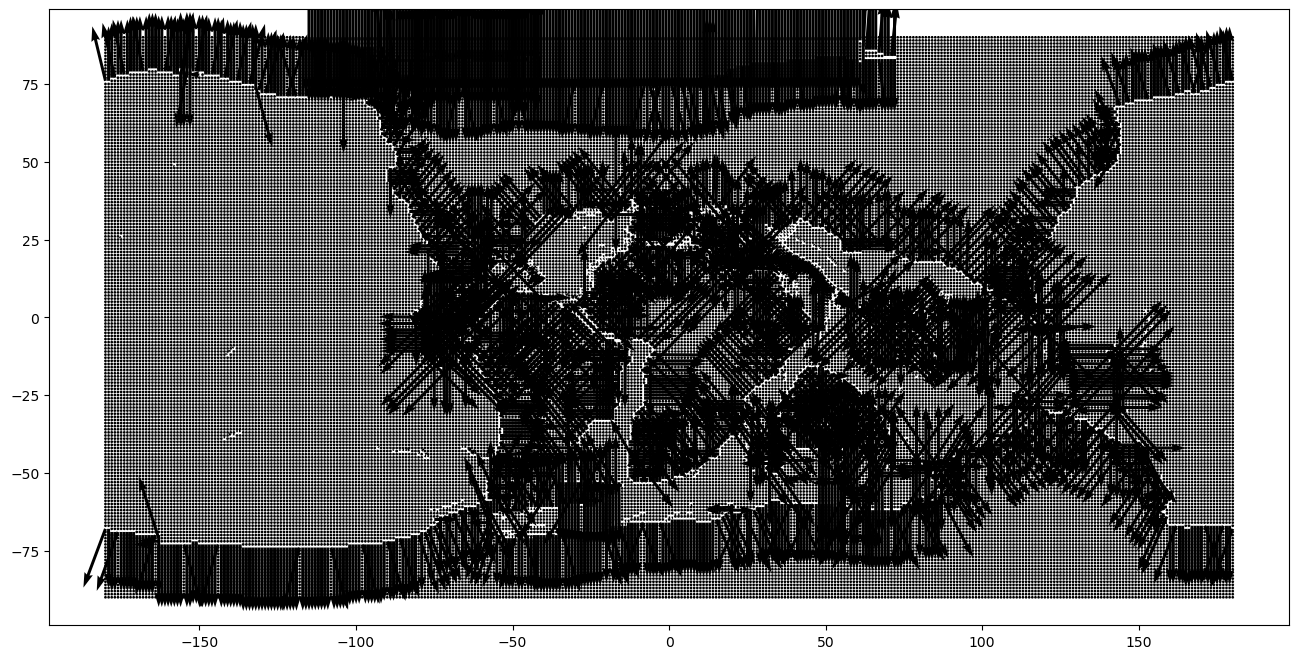

In [8]:
fig, ax = plt.subplots(figsize=(16,8))
# ax.scatter(points[100]["test"].lon, points[100]["test"].lat, c=points[100]["test"].U)
# ax.scatter(slabs[100]["test"].lon, slabs[100]["test"].lat)
ax.quiver(points[100]["test"].lon, points[100]["test"].lat, points[100]["test"].GPE_force_lon, points[100]["test"].GPE_force_lat)

In [9]:
plate_torques[0]["test"]

,Unnamed: 0,plateID,area,pole_lat,pole_lon,pole_angle,centroid_lon,centroid_lat,centroid_vel_lon,centroid_vel_lat,...,GPE_torque_x,GPE_torque_y,GPE_torque_z,GPE_force_lat,GPE_force_lon,mantle_drag_torque_x,mantle_drag_torque_y,mantle_drag_torque_z,mantle_drag_force_lat,mantle_drag_force_lon
0,0,101.0,5.741222e+13,39.164921,142.154874,-0.228610,-88.081093,59.241102,4.040370,2.433493,...,3.834716e+15,-6.004873e+15,-7.219013e+15,-2.313624e+22,-5.708157e+22,-2.096817e+16,1.151383e+16,2.451570e+16,1.310570e+23,1.467237e+23
1,1,201.0,4.337986e+13,73.672896,-168.122794,-0.190696,-46.638724,-20.815938,4.435898,1.862203,...,-1.268797e+15,4.265960e+15,-1.259604e+16,-1.278359e+22,-8.400553e+22,-3.448423e+16,-4.664123e+16,1.943274e+16,3.637527e+23,1.388933e+23
2,2,224.0,3.360022e+12,13.332078,-73.222144,0.580442,-74.537554,14.508886,3.883477,0.195567,...,-7.100048e+14,-6.423122e+14,-1.125430e+15,5.450716e+21,-7.627425e+21,-5.001055e+13,4.319565e+11,2.052993e+14,3.063513e+20,1.288195e+21
3,3,301.0,6.520304e+13,39.972059,-27.582163,0.111646,76.915763,54.602266,0.618945,1.130884,...,-3.941027e+15,3.521022e+15,1.370486e+15,-2.953476e+22,-8.120052e+21,-1.135111e+16,7.269230e+15,-1.833395e+16,-8.092475e+22,-9.108561e+22
4,4,406.0,5.063648e+11,39.972059,-27.582163,0.111646,159.386049,54.369650,1.664197,1.237564,...,-3.548203e+14,8.310426e+13,-2.560192e+14,-3.003164e+20,-2.821438e+21,-2.013395e+13,-1.367732e+14,2.132367e+13,-8.607522e+20,2.309117e+20
5,5,501.0,1.041139e+13,27.311086,13.098072,0.586745,76.377697,14.877796,0.405666,5.635353,...,4.314397e+15,-2.227259e+15,4.325113e+15,3.005580e+22,2.851021e+22,-9.612862e+15,9.335358e+15,-2.666943e+16,-7.352844e+22,-1.753525e+23
6,6,503.0,5.415694e+12,27.946921,3.831775,0.549358,48.273298,23.928864,0.272064,3.922608,...,2.950910e+15,-1.821145e+15,-1.719919e+15,2.175353e+22,-1.157889e+22,6.537574e+14,4.300368e+15,-8.736336e+15,-1.512675e+22,-6.029329e+22
7,7,511.0,1.075609e+13,18.941872,32.561591,0.708642,83.209411,-12.647314,0.549630,6.758586,...,3.588578e+15,5.958413e+14,4.711602e+15,2.225359e+22,3.070649e+22,-1.849968e+16,-4.342147e+15,-3.079378e+16,-1.137637e+23,-2.004927e+23
8,8,566.0,3.374902e+11,3.256458,-56.922635,1.435562,123.476163,-6.493379,4.589931,0.908091,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.523541e+15,3.032860e+15,-2.050080e+14,3.469679e+22,-1.272787e+21
9,9,607.0,5.386235e+11,23.689944,-0.808826,0.580781,94.263387,14.655449,0.421697,6.456240,...,2.696094e+14,-1.656353e+14,1.021220e+15,1.634479e+21,6.593071e+21,-9.773464e+14,4.957140e+14,-2.157566e+15,-5.974659e+21,-1.421258e+22


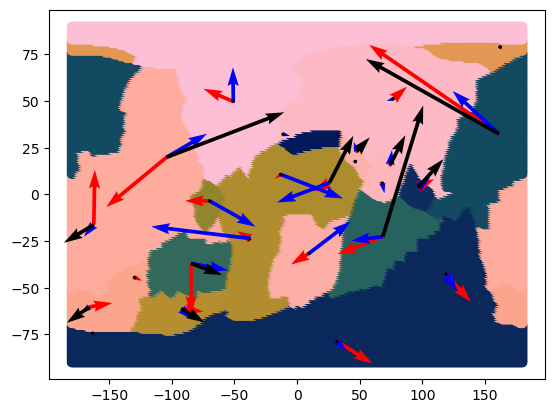

In [10]:
torques = plate_torques[100]["test"]

fig, ax = plt.subplots()
ax.scatter(points[100]["test"].lon, points[100]["test"].lat, c=points[100]["test"].plateID, cmap="cmc.batlowS")
ax.quiver(torques.centroid_lon, torques.centroid_lat, torques.mantle_drag_force_lon, torques.mantle_drag_force_lat, color="r")
ax.quiver(torques.centroid_lon, torques.centroid_lat, torques.GPE_force_lon, torques.GPE_force_lat, color="b")
ax.quiver(torques.centroid_lon, torques.centroid_lat, torques.slab_pull_force_lon, torques.slab_pull_force_lat, color="k")
# ax.quiver(torques.centroid_lon, torques.centroid_lat, plate_torques[100]["test"].slab_pull_force_lon, plate_torques[100]["test"].slab_pull_force_lat)

### Optimisation

Now we want to find the slab pull and mantle drag coefficients that minimise the residual torque of present-day plate motions. We select the oceanic Pacific, Nazca and Cocos plates to minimise the residual.

In [44]:
def optimise_coefficients(plate_torques, options, plates_of_interest=None, grid_size=500):
    # Generate grid
    viscs = np.linspace(4.33e19,3.19e+20,500)
    sp_consts = np.linspace(0.05,1,500)
    visc_grid = np.repeat(viscs[:, np.newaxis], 500, axis=1)
    sp_const_grid = np.repeat(sp_consts[np.newaxis, :], 500, axis=0)
    ones_grid = np.ones_like(visc_grid)

    # Filter torques
    torques = plate_torques.copy()
    if plates_of_interest:
        torques.plateID = torques.plateID.astype(int)
        torques = torques[torques.plateID.isin(plates_of_interest)]

    # Get total area
    total_area = torques["area"].sum()

    residual_magnitude = np.zeros_like(sp_const_grid)

    # Get torques
    for k, _ in enumerate(plates_of_interest):
        residual_x = np.zeros_like(sp_const_grid); residual_y = np.zeros_like(sp_const_grid); residual_z = np.zeros_like(sp_const_grid)

        if options["Slab pull torque"] and "slab_pull_torque_x" in torques.columns:
            residual_x += torques.slab_pull_torque_x.iloc[k] * sp_const_grid
            residual_y += torques.slab_pull_torque_y.iloc[k] * sp_const_grid
            residual_z += torques.slab_pull_torque_z.iloc[k] * sp_const_grid

        # Add GPE torque
        if options["GPE torque"] and "GPE_torque_x" in torques.columns:
            residual_x += torques.GPE_torque_x.iloc[k] * ones_grid
            residual_y += torques.GPE_torque_y.iloc[k] * ones_grid
            residual_z += torques.GPE_torque_z.iloc[k] * ones_grid

        # Compute magnitude of driving torque
        driving_magnitude = np.sqrt(residual_x**2 + residual_y**2 + residual_z**2) * (torques.area.iloc[k]/total_area)

        # Add Bending torque
        if options["Bending torque"] and "bending_torque_x" in torques.columns:
            residual_x += torques.bending_torque_x.iloc[k] * ones_grid
            residual_y += torques.bending_torque_y.iloc[k] * ones_grid
            residual_z += torques.bending_torque_z.iloc[k] * ones_grid

        # Add mantle drag torque
        if options["Mantle drag torque"] and "mantle_drag_torque_x" in torques.columns:
            residual_x += torques.mantle_drag_torque_x.iloc[k] * visc_grid / 150e3
            residual_y += torques.mantle_drag_torque_y.iloc[k] * visc_grid / 150e3
            residual_z += torques.mantle_drag_torque_z.iloc[k] * visc_grid / 150e3

        # Compute magnitude of residual
        residual_magnitude += np.sqrt(residual_x**2 + residual_y**2 + residual_z**2) * (torques.area.iloc[k]/total_area)

        # Divide residual by driving torque
        residual_normalised = np.log(residual_magnitude / driving_magnitude)

    p = plt.imshow(residual_normalised)
    plt.colorbar(p)
    plt.show()

    opt_val = np.amin(residual_normalised)
    print(opt_val)
    
    # Find the indices of the minimum value directly using np.argmin
    opt_i, opt_j = np.unravel_index(np.argmin(residual_magnitude), residual_magnitude.shape)
    opt_visc = visc_grid[opt_i, opt_j]
    opt_sp_const = sp_const_grid[opt_i, opt_j]
    
    print("Optimum viscosity [Pa s]:", opt_visc)
    print("Optimum Drag Coefficient [Pa s/m]:", opt_visc / 150e3)
    print("Optimum Slab Pull constant:", opt_sp_const)

    return opt_visc, opt_sp_const

0.8453998957986625
0.02342566088978927
0.1311744433115482


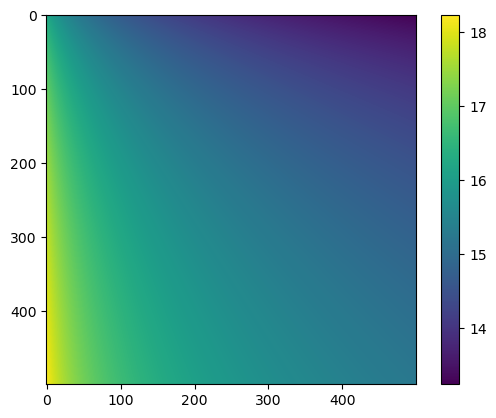

13.244981888438861
Optimum viscosity [Pa s]: 4.33e+19
Optimum Drag Coefficient [Pa s/m]: 288666666666666.7
Optimum Slab Pull constant: 0.05


In [45]:
# Select case for optimisation, or replace with cases to run for all cases 
optimisation_case = "test"
optimisation_time = 0
optimisation_plates = [901, 909, 911]

# Run optimisation
optimum_coefficients = optimise_coefficients(plate_torques[optimisation_time][optimisation_case], options[optimisation_case], optimisation_plates)

In [ ]:
print(optimum_coefficients)

(4.33e+19, 0.08236472945891783)


### Plotting



UnboundLocalError: cannot access local variable 'gplot' where it is not associated with a value

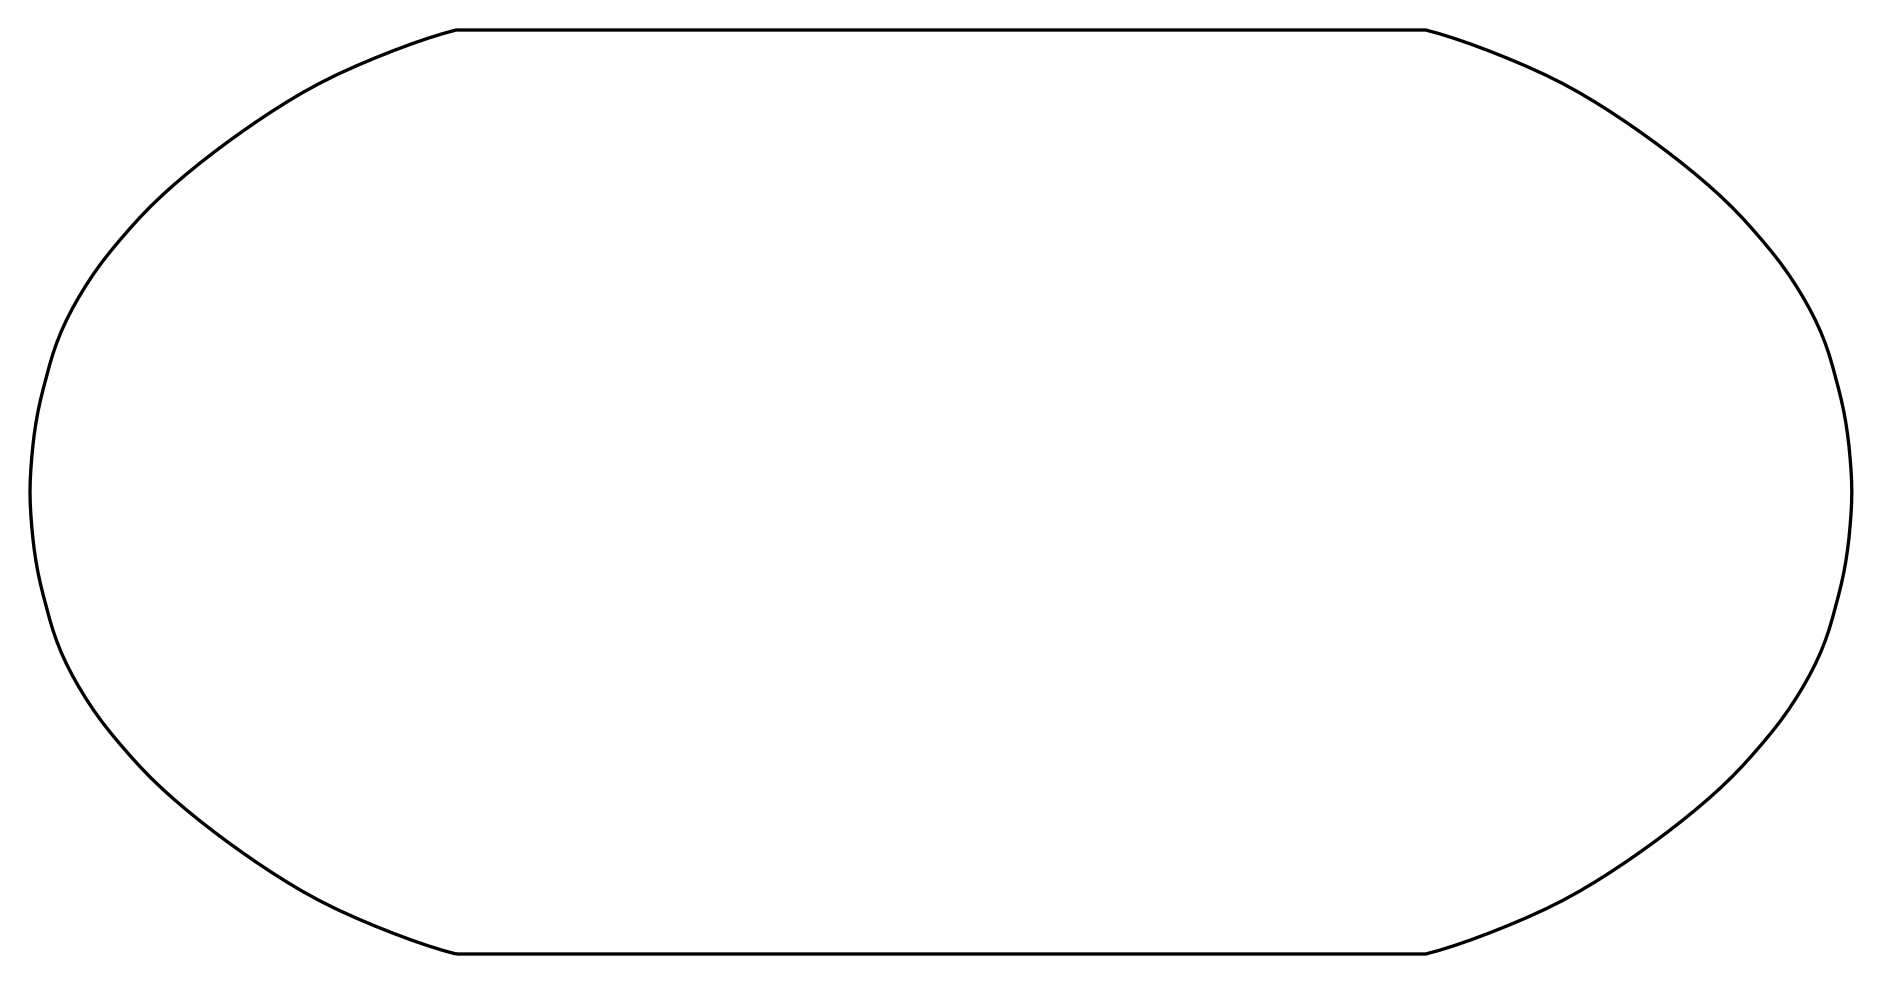

In [ ]:
for reconstruction_time in reconstruction_times:
    for case in cases:
        fig = plot_torques(reconstruction_time, slabs[reconstruction_time][case], plate_torques[reconstruction_time][case], seafloor[reconstruction_time], reconstruction_files)